In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataPreparation as dp
import math
%matplotlib inline
plt.style.use('fivethirtyeight')

directory = 'C:\\Users\\Szafran\\Desktop\\python\\TitanicCompetition'
os.chdir(directory)

data = pd.read_csv('train.csv')

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)
val_X = val_set.drop('Survived', axis=1)
val_y = val_set['Survived'].copy()


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
from sklearn.model_selection import train_test_split
#0.2 test set size, stratified accordingly to target variable (~0.38 survival rate)
train_set, val_set = train_test_split(data, random_state=42, stratify=data['Survived'], test_size=0.2)

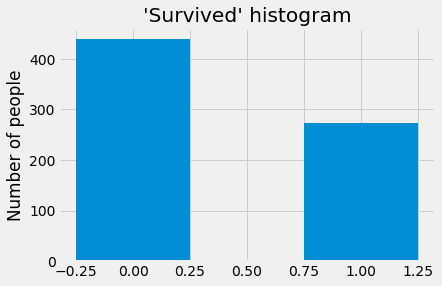

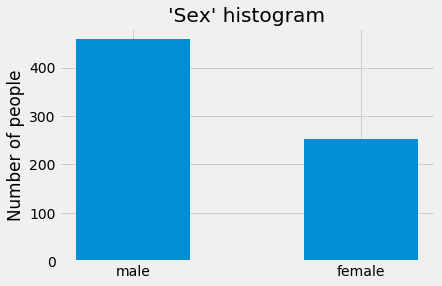

In [5]:
#preparing some functions for data visualization:
def draw_binary_hist(feature):
    plt.hist(train_set[feature], bins=[-.25,.75, 1.25], width=0.5)
    plt.title(f"'{feature}' histogram")
    plt.ylabel('Number of people')
    plt.show()
    
draw_binary_hist('Survived')
draw_binary_hist('Sex')

In [6]:
from scipy.stats import pearsonr
pearsonr(pd.factorize(train_set['Sex'])[0], train_set['Survived'])

(0.5491711109145092, 2.480271713003673e-57)

The correlation between Sex and target variable is clearly visible and statistically significant.

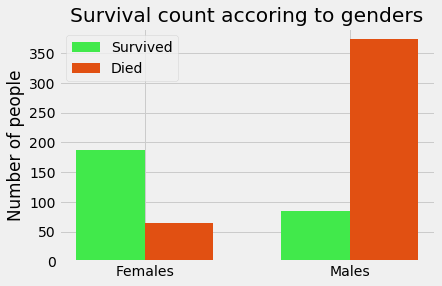

In [7]:
plt.bar([1, 1.30], train_set[train_set['Survived']==1].groupby(['Sex', 'Survived'])['Survived'].count(), width = 0.1, color='#41e94b', label='Survived')
plt.bar([1.1, 1.4], train_set[train_set['Survived']==0].groupby(['Sex', 'Survived'])['Survived'].count(), width = 0.1, color='#e15012', label='Died')
plt.legend()
plt.xticks([1.05, 1.35], ['Females', 'Males'])
plt.ylabel('Number of people')
plt.title('Survival count accoring to genders')
plt.show()

We observe huge discrepancy between the survival rate of men and women, obviously Sex variable is a great feature.

Let's see if there's any data leakage and if PassengerId can provide us with any valuable informations.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


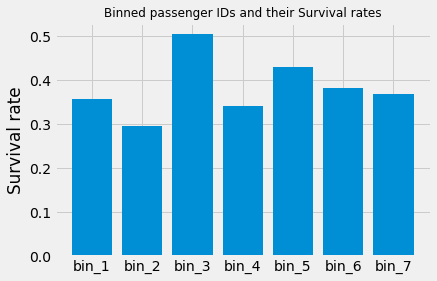

In [10]:
train_set['id_bin'] = pd.cut(train_set['PassengerId'], 7) #creating a feature that groups sorted ascending passengerId into 7 bins
plt.bar([f"bin_{i}" for i in range(1, 8)], train_set.groupby(['id_bin'])['Survived'].mean())
plt.title('Binned passenger IDs and their Survival rates', size=12)
plt.ylabel('Survival rate')
plt.show()

Passenger ID does not seem to produce anything but noise.

Let's explore Passenger's Class variable.

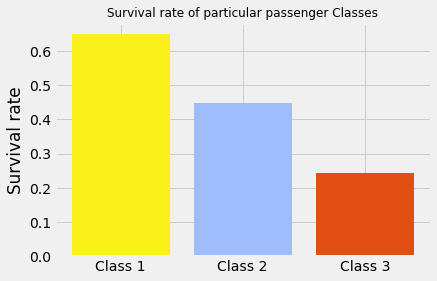

In [11]:
train_set.groupby('Pclass')['Survived'].mean()
plt.bar([f'Class {i}' for i in range(1,4)], train_set.groupby('Pclass')['Survived'].mean(), color=['#fbf11a', '#9fbcfc', '#e15012'])
plt.title('Survival rate of particular passenger Classes', size=12)
plt.ylabel('Survival rate')
plt.show()

Obviously chances of survival grew with the class of the passenger.
Apparently, it's an arithmetic series, being in class 3 you had only ~0.25 chances for survival, it grew approximately by 0.2 with every class.

Let's try to see if we can engineer an useful feature by combining Sex and Pclass

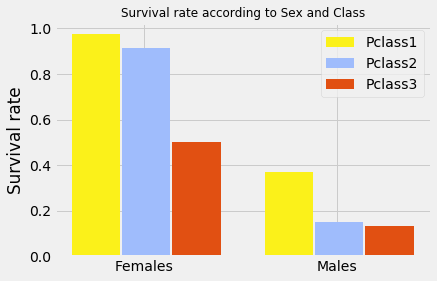

In [12]:
plt.bar([1,3], train_set[train_set['Pclass']==1].groupby(['Sex'])['Survived'].mean(), color=['#fbf11a'], width=0.5, label='Pclass1')
plt.bar([1.52,3.52], train_set[train_set['Pclass']==2].groupby(['Sex'])['Survived'].mean(), color=['#9fbcfc'], width=0.5, label='Pclass2')
plt.bar([2.04,4.04], train_set[train_set['Pclass']==3].groupby(['Sex'])['Survived'].mean(), color=['#e15012'], width=0.5, label='Pclass3')
plt.xticks([1.5, 3.5], ['Females', 'Males'])
plt.ylabel('Survival rate')
plt.title('Survival rate according to Sex and Class', size=12)
plt.legend()
plt.show()

Wow! almost 100% of survival rate for women in 1st class and over 90% for women in 2nd class!
Also, sample size is convincing - it's circa 100 for each class so the results are convincing and reliable

The first continuous variable we meet is Age. Let's try to bin it and see what results it will produce.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


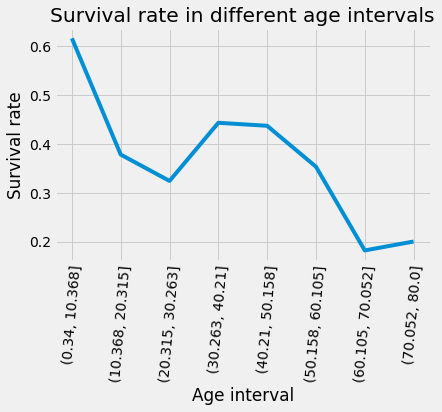

In [13]:
train_set['Age'] = train_set['Age'].where(lambda x: x<100, train_set['Age'].median())
train_set['Age_bins'] = pd.cut(train_set['Age'],8)

plt.plot(train_set.groupby('Age_bins')['Survived'].mean().values)
plt.xticks([i for i in range(8)], train_set['Age_bins'].unique().sort_values(), rotation=85)
plt.xlabel('Age interval')
plt.ylabel('Survival rate')
plt.title('Survival rate in different age intervals')
plt.show()


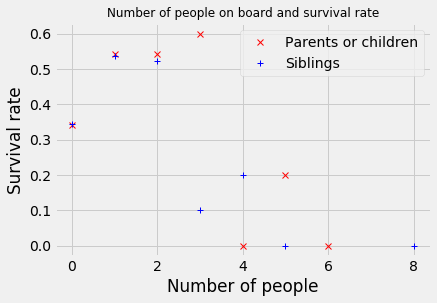

In [14]:
#let's move on to relatives
plt.plot(train_set.groupby('Parch')['Survived'].mean(), 'rx', label='Parents or children')
plt.plot(train_set.groupby('SibSp')['Survived'].mean(), 'b+', label='Siblings')
plt.xlabel('Number of people')
plt.ylabel('Survival rate')
plt.title('Number of people on board and survival rate', size=12)
plt.legend()
plt.show()

it seems like these variables are tightly correlated. we'll merge them later on.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


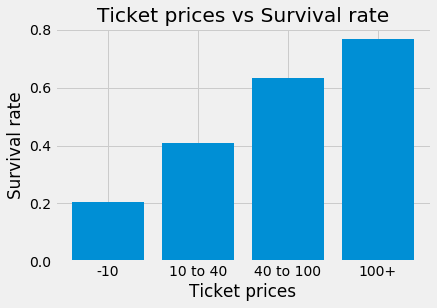

In [15]:
#let's see what we can do with Fare:
train_set['Fare_bins'] = pd.cut(train_set['Fare'], [-1000,10,40,100,1000], labels=[1,2,3,4])
train_set['Fare_bins'] = train_set['Fare_bins'].astype(int)
plt.bar([1,2,3,4], train_set.groupby('Fare_bins')['Survived'].mean())
plt.xticks([1,2,3,4], ['-10', '10 to 40', '40 to 100', '100+'])
plt.xlabel('Ticket prices')
plt.ylabel('Survival rate')
plt.title('Ticket prices vs Survival rate')
plt.show()

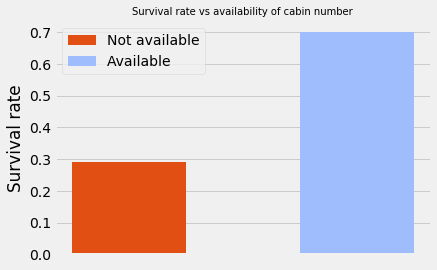

In [16]:
#Cabin:
plt.bar(1, train_set[train_set['Cabin'].isnull()]['Survived'].mean(), label='Not available', width=0.5, color='#e15012')
plt.bar(2, train_set[train_set['Cabin'].isnull()==False]['Survived'].mean(), label='Available', color='#9fbcfc', width=0.5)
plt.xticks([])
plt.ylabel('Survival rate')
plt.title('Survival rate vs availability of cabin number', size=10)
plt.legend()
plt.show()

So far, after data visualization, we can come up with following conclusions:
- useful variables are: Sex, Age, Pclass, Fare, SibSp, Parch.

Let's try to build a simple benchmark Random Forest model using these variables.

In [20]:
from sklearn.preprocessing import LabelEncoder
def prepare_variables(train_set):
    #categorical variables:
    train_set['Embarked'] = train_set['Embarked'].fillna('Missing')
    features_cat = train_set[['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']].copy()
    encoder = LabelEncoder()
    features_cat_encoded = pd.DataFrame()
    for i in features_cat.columns:
        features_cat_encoded[i] = encoder.fit_transform(features_cat[i])

    features_cat_encoded.head()

    #continous variables:
    features_num = train_set[['Age', 'Fare']]
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    features_num = pd.DataFrame(imputer.fit_transform(features_num), columns = features_num.columns)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_num_encoded = pd.DataFrame(scaler.fit_transform(features_num), columns = features_num.columns)

    features_prepared = pd.concat([features_cat_encoded, features_num_encoded], axis=1)
    return features_prepared

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(prepare_variables(train_set), train_set['Survived'])

from sklearn.model_selection import cross_val_score
print(cross_val_score(model_rf, prepare_variables(val_X), val_y, scoring='accuracy').mean())

print(prepare_variables(train_set).columns)
model_rf.feature_importances_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.8158730158730159
Index(['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Age', 'Fare'], dtype='object')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([0.27471431, 0.08287348, 0.05348403, 0.03885116, 0.02964013,
       0.2451814 , 0.27525549])

81% accuracy on validation set!
Most valuable variables are definitely Fare, Sex and Age.

Let's try to engineer some features and improve it even more.

Next model we'll try will be Random Forest again.

During vizualization of our data we found out that it might be useful to:
- combine Sex and Pclass,
- Add together SibSp and Parch and create Relatives variable
- create variable is_Cabin that will inform us whether we have an access to the information about a cabin person occupied

In [21]:
train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)
train_X = train_set.drop('Survived', axis=1)
train_y = train_set['Survived'].copy()
val_X = val_set.drop('Survived', axis=1)
val_y = val_set['Survived'].copy()

def prepare_variables_RF(features):
    #creating variables
    features['Relatives'] = features['Parch'] + features['SibSp']
    features['Pclass_Sex'] = [str(features['Pclass'][i]) + '_' + features['Sex'][i] for i in features.index]
    features['Is_Cabin'] = 1
    features['Is_Cabin'] = features['Is_Cabin'].where(features['Cabin'].isnull()==False, 0)
    
    #categorical variables
    features_cat = features[['Pclass_Sex', 'Relatives', 'Is_Cabin']].copy()
    encoder = LabelEncoder()
    features_cat_encoded = pd.DataFrame()
    for i in features_cat.columns:
        features_cat_encoded[i] = encoder.fit_transform(features_cat[i])
    
    #numerical variables:
    features_num = features[['Age', 'Fare']]
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    features_num = pd.DataFrame(imputer.fit_transform(features_num), columns = features_num.columns)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_num_encoded = pd.DataFrame(scaler.fit_transform(features_num), columns = features_num.columns)

    features_prepared = pd.concat([features_cat_encoded, features_num_encoded], axis=1)
    
    return features_prepared

train_encoded, val_encoded = prepare_variables_RF(train_X), prepare_variables_RF(val_X)

from sklearn.ensemble import RandomForestRegressor
model_rf2 = RandomForestClassifier()
model_rf2.fit(train_encoded, train_y)

print(cross_val_score(model_rf2, val_encoded, val_y, scoring='accuracy').mean())
print(model_rf2.feature_importances_)

0.8214285714285714
[0.31303597 0.06840796 0.04335857 0.26885306 0.30634444]


Prediction accuracy has slightly dropped. Let's come back to the previous, simple model and explore it further to fine tune it.

Let's begin with confusion matrix analysis.

In [23]:
from sklearn.model_selection import cross_val_predict
cross_val_predictions = cross_val_predict(model_rf, prepare_variables(val_X), val_y, cv=4)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(val_y, cross_val_predictions)
print(conf_matrix)
precision = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
recall = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0])
print(f"Out of {conf_matrix[1][1]+conf_matrix[0][1]} people classified as 'Survived', {conf_matrix[1][1]} of them ({round(precision*100, 2)}%) were actual survivors.")
print(f"Out of {conf_matrix[1][0]+conf_matrix[1][1]} real survivors, {conf_matrix[1][1]} of them ({round(recall*100, 2)}%) were correctly classified as survivors.")

[[87 18]
 [14 60]]
Out of 78 people classified as 'Survived', 60 of them (76.92%) were actual survivors.
Out of 74 real survivors, 60 of them (81.08%) were correctly classified as survivors.


Let's plot ROC curve.

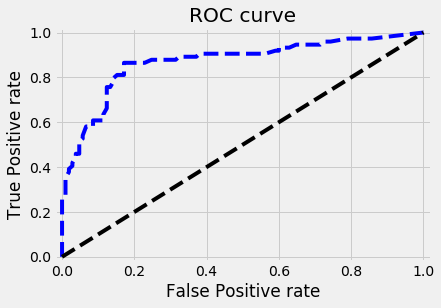

In [24]:
from sklearn.metrics import roc_curve
cv_predictions_proba = cross_val_predict(model_rf, prepare_variables(val_X), val_y, cv=5, method='predict_proba')
cv_predictions_proba_survived = cv_predictions_proba[:, 1]
fpr, tpr, thresholds = roc_curve(val_y, cv_predictions_proba_survived)
plt.plot(fpr, tpr, 'b--')
plt.plot([0,1], [0,1], 'k--')
plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')
plt.title('ROC curve')
plt.xlim([-0.02,1.02])
plt.ylim([-0.02,1.02])
plt.savefig('ROC of the best RF model to date.png')
plt.show()

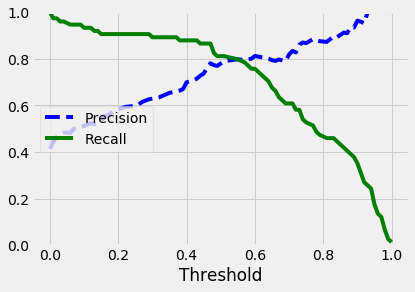

In [25]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresh = precision_recall_curve(val_y, cv_predictions_proba_survived)
def plot_precision_recall_vs_threshold(prec,rec,thresh):
    plt.plot(thresh, prec[:-1], 'b--', label="Precision")
    plt.plot(thresh, rec[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.show()

plot_precision_recall_vs_threshold(prec, rec, thresh)

We'll try different thresholds later. Now let's try to tune hyperparameters of out model.

In [26]:
from sklearn.model_selection import GridSearchCV

grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
    
rf_tuned = RandomForestClassifier()

grid_search = GridSearchCV(rf_tuned, grid, cv=3, n_jobs=-1, verbose=-2)
grid_search.fit(prepare_variables(train_X), train_y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [27]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 200}

In [28]:
grid = {
    'bootstrap': [True],
    'max_depth': [100, 105, 110],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [10, 12,15],
    'n_estimators': [250, 300, 400]}
    
rf_tuned = RandomForestClassifier()

grid_search = GridSearchCV(rf_tuned, grid, cv=3, n_jobs=-1, verbose=-2)
grid_search.fit(prepare_variables(train_X), train_y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [29]:
grid_search.best_params_

best_model = grid_search.best_estimator_

print(cross_val_score(best_model, prepare_variables(val_X), val_y, scoring='accuracy').mean())

0.8044444444444444


A there's a decrease comparing to the pre-tuning model. Let's fit validation data onto the first model and submit kaggle predicitons.

In [30]:
test = pd.read_csv('test.csv')
predictions = model_rf.predict(prepare_variables(test))

file_to_submit = pd.DataFrame(test['PassengerId'])
file_to_submit['Survived'] = predictions

file_to_submit.to_csv('RandomForestSubmission.csv', index=False)

<img src="submission low.png" width="800" />

Unfortunately the model performs not as good on the test set from the public leaderboard as on the validation set. The reason for that might be a different distribution of the test set or overfitting. Let's try a different approach.

We'll use:
- Age as continous variable
- Fare as continous variable
- Number of relatives
- Transform categorical variables into dummies


In [31]:
def dataPrepare(features):
    #let's drop Name, Cabin, PassengerId and Ticket (is Ticket holding any info?)
    features = features.drop(['Name', 'Cabin', 'PassengerId', 'Ticket', 'Fare', 'Embarked'], axis=1)
    
    #Missing values - we only have them in Age feature, lets fill them with median
    features['Age'] = features['Age'].where(lambda x: x<100, features['Age'].median())
    #Relatives
    def relatives_summarizer(rels):
        if rels ==0:
            rels = "Solo"
        elif rels in range (1,4):
            rels = 'Few_relatives'
        else:
            rels = 'Many_relatives'
        return rels
    
    features['Relatives'] = features['Parch'] + features['SibSp']
    features['Relatives'] = features['Relatives'].apply(lambda x: relatives_summarizer(x))
        
    #categorical variables
    features_cat = pd.get_dummies(features[['Pclass', 'Sex', 'Relatives']].astype(str).copy())
    
    #standarization
    features_num_before = features.drop(['Pclass', 'Sex', 'Relatives'], axis=1)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_num = pd.DataFrame(scaler.fit_transform(features_num_before), columns=features_num_before.columns, index=features.index)
    
    #merge
    features_final = pd.concat([features_cat, features_num], axis=1)
    features_final = features_final.drop('Relatives_Few_relatives', axis=1)
    return features_final

In [32]:
train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)
val_X = val_set.drop('Survived', axis=1)
val_y = val_set['Survived'].copy()
features = dataPrepare(train_set.drop('Survived', axis=1))
attributes = train_set['Survived'].copy()

grid = [{'n_estimators':[3,10,30,35,40],
         'max_features':[2,3,4,5,6],
         'bootstrap':[False, True],
         'n_estimators':[2,3,10,15,20],
         'max_depth':[1,2,3],
         'criterion':['gini', 'entropy']}]
model = GridSearchCV(RandomForestClassifier(), grid, scoring='accuracy', cv=5)
model.fit(features, attributes)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [33]:
mean_score = cross_val_score(model, dataPrepare(val_X), val_y, scoring='accuracy').mean()
print("Mean score of cross validation using accuracy method", mean_score)

Mean score of cross validation using accuracy method 0.7822222222222223


Let's upload this one to kaggle.

In [36]:
test_set = pd.read_csv('test.csv')
test_ready = dataPrepare(test_set)
predictions = model.predict(test_ready)
file_to_submit = pd.DataFrame(test_set['PassengerId'])
file_to_submit['Survived'] = predictions

file_to_submit.to_csv('submissionRF.csv', index=False)

<img src="submission good.png" width="800" />

We scored ~79%, what brings us up to position 3003, that's 82 percentile. not bad!